# 二 ⼿动⽣成⼆分类任务的数据集

## 0 数据生成

In [39]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt

devc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 参数设置
seed = 114514
n_train = 7000  # 训练集样本数
n_test = 3000  # 测试集样本数   
p = 200  # 特征维度
h = 50  
mean = 0.3
std = 1


In [40]:
def generate_data(seed, n_train, n_test, p, mean, std, device):
    # 固定随机种子，保证可复现
    torch.manual_seed(seed)
    if device.type == "cuda":
        torch.cuda.manual_seed(seed)

    n_total = n_train + n_test
    half = n_total // 2

    x1 = torch.normal(mean=mean, std=std, size=(half, p), device=device)
    x2 = torch.normal(mean=-mean, std=std, size=(half, p), device=device)

    X = torch.cat([x1, x2], dim=0)
    y = torch.cat(
        [
            torch.zeros(half, dtype=torch.long, device=device),
            torch.ones(half, dtype=torch.long, device=device),
        ]
    )

    # 打乱
    idx = torch.randperm(n_total)
    X = X[idx]
    y = y[idx]

    # 划分数据
    return X[:n_train], X[n_train:], y[:n_train], y[n_train:]


X_train, X_test, y_train, y_test = generate_data(
    seed, n_train, n_test, p, mean, std, devc
)


def train_iter(batch_size, features=X_train, labels=y_train):
    num_examples = len(features)
    indices = torch.randperm(num_examples)
    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i : min(i + batch_size, num_examples)]
        yield features[batch_indices], labels[batch_indices]


def test_iter(batch_size, features=X_test, labels=y_test):
    num_examples = len(features)
    indices = torch.arange(0, num_examples)
    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i : min(i + batch_size, num_examples)]
        yield features[batch_indices], labels[batch_indices]

## 1 ⼿动实现前馈神经⽹络解决上述回归、⼆分类、多分类任务
分析实验结果并绘制训练集和测试集的loss曲线

In [41]:
class Net:
    def __init__(self, input_dim, hidden_dim, output_dim, device):
        self.w1 = torch.normal(
            mean=0,
            std=(2 / input_dim) ** 0.5,
            size=(input_dim, hidden_dim),
            requires_grad=True,
            device=device,
        )  # He
        self.w2 = torch.normal(
            mean=0,
            std=(1 / hidden_dim) ** 0.5,
            size=(hidden_dim, output_dim),
            requires_grad=True,
            device=device,
        )  # He
        self.b1 = torch.zeros(hidden_dim, requires_grad=True, device=device)
        self.b2 = torch.zeros(output_dim, requires_grad=True, device=device)

    def net_MLP_BinaryClassification(self, X):
        z1 = X @ self.w1 + self.b1
        a1 = torch.relu(z1)
        z2 = a1 @ self.w2 + self.b2
        a2 = torch.sigmoid(z2)
        return a2

    def forward(self, X):
        return self.net_MLP_BinaryClassification(X)

    def parameters(self):
        return [self.w1, self.b1, self.w2, self.b2]

In [42]:
class Loss:
    def binaryCrossEntropyLoss(self, y_hat, y):
        return -torch.mean(
            y * torch.log(torch.clamp(y_hat, 1e-12, 1 - 1e-12))
            + (1 - y) * torch.log(torch.clamp(1 - y_hat, 1e-12, 1 - 1e-12))
        )

    def calc(self, y_hat, y):
        return self.binaryCrossEntropyLoss(y_hat, y)

In [43]:
class Optimizer:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def SGD(self):
        for param in self.params:
            param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

    def step(self):
        self.SGD()

In [44]:
def eval_loss_fn(data_iter, net, loss, batch_size, device):
    # net.eval()
    with torch.no_grad():
        num_total = 0
        loss_val = 0
        for X_batch, y_batch in data_iter(batch_size=batch_size):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_hat = net.forward(X_batch)
            num_total += len(y_batch)
            loss_val += loss.calc(y_hat, y_batch.view(-1, 1)).item() * len(y_batch)
        loss_val /= num_total
    # net.train()
    return loss_val

In [45]:
def train(
    net,
    loss,
    optimizer,
    train_iter,
    test_iter,
    evaluate,
    num_epochs,
    batch_size,
    device,
):
    train_loss_list, test_loss_list = [], []
    for epoch in range(num_epochs):
        num_data = 0
        train_loss_val, test_loss_val = 0, 0
        for X_batch, y_batch in train_iter(batch_size):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_hat = net.forward(X_batch)
            loss_val = loss.calc(y_hat, y_batch.view(-1, 1))
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            num_data += len(y_batch)
            train_loss_val += loss_val.item() * len(y_batch)
        train_loss_val /= num_data
        train_loss_list.append(train_loss_val)
        test_loss_val = evaluate(test_iter, net, loss, batch_size, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch+1}, Train Loss: {train_loss_val:.4f}, Test Loss: {test_loss_val:.4f}"
        )
    return train_loss_list, test_loss_list

In [46]:
lr = 0.03
num_epochs = 32
batch_size = 1024
net = Net(p, h, 1, devc)
loss = Loss()
optimizer = Optimizer(net.parameters(), lr)

train_loss_list, test_loss_list = train(
    net,
    loss,
    optimizer,
    train_iter,
    test_iter,
    eval_loss_fn,
    num_epochs,
    batch_size,
    devc,
)

Epoch 1, Train Loss: 0.6096, Test Loss: 0.4696
Epoch 2, Train Loss: 0.4056, Test Loss: 0.3329
Epoch 3, Train Loss: 0.2940, Test Loss: 0.2519
Epoch 4, Train Loss: 0.2257, Test Loss: 0.1991
Epoch 5, Train Loss: 0.1806, Test Loss: 0.1629
Epoch 6, Train Loss: 0.1489, Test Loss: 0.1367
Epoch 7, Train Loss: 0.1258, Test Loss: 0.1170
Epoch 8, Train Loss: 0.1083, Test Loss: 0.1019
Epoch 9, Train Loss: 0.0947, Test Loss: 0.0899
Epoch 10, Train Loss: 0.0838, Test Loss: 0.0803
Epoch 11, Train Loss: 0.0750, Test Loss: 0.0724
Epoch 12, Train Loss: 0.0678, Test Loss: 0.0658
Epoch 13, Train Loss: 0.0617, Test Loss: 0.0602
Epoch 14, Train Loss: 0.0565, Test Loss: 0.0555
Epoch 15, Train Loss: 0.0521, Test Loss: 0.0514
Epoch 16, Train Loss: 0.0483, Test Loss: 0.0478
Epoch 17, Train Loss: 0.0450, Test Loss: 0.0447
Epoch 18, Train Loss: 0.0420, Test Loss: 0.0420
Epoch 19, Train Loss: 0.0394, Test Loss: 0.0396
Epoch 20, Train Loss: 0.0371, Test Loss: 0.0374
Epoch 21, Train Loss: 0.0351, Test Loss: 0.0354
E

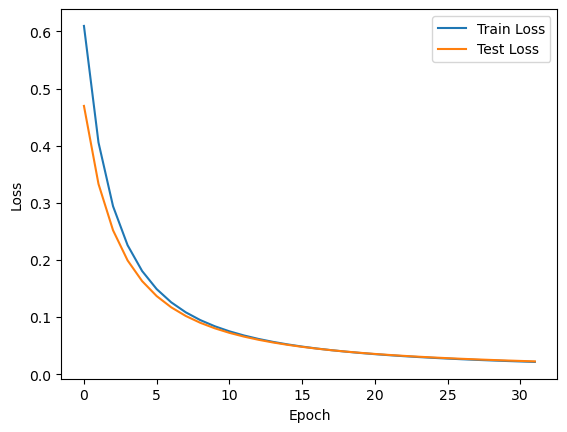

In [47]:
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 2 利⽤torch.nn实现前馈神经⽹络解决上述回归、⼆分类、多分类任务
分析实验结果并绘制训练集和测试集的loss曲线

In [48]:
class Net(nn.Module):
    def __init__(self, input_dim, hiden_dim, output_dim, device):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hiden_dim),
            nn.ReLU(),
            nn.Linear(hiden_dim, output_dim),
            # nn.Sigmoid(),
        ).to(device)
        with torch.no_grad():
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    init.kaiming_normal_(m.weight)
                    m.bias.zero_()

    def forward(self, X):
        return self.model(X).view(-1)

In [49]:
class Loss:
    def __init__(self):
        self.loss_fn = nn.BCEWithLogitsLoss()

    def calc(self, y_hat, y):
        return self.loss_fn(y_hat, y.float())

In [50]:
class Optimizer:
    def __init__(self, params, lr):
        self.optim = optim.SGD(params, lr=lr)

    def zero_grad(self):
        self.optim.zero_grad()

    def step(self):
        self.optim.step()

In [51]:
def eval_loss_fn(net, loss, test_iter, batch_size, device):
    net.eval()
    with torch.no_grad():
        n_total = 0
        total_loss = 0
        for X_batch, y_batch in test_iter(batch_size):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_hat = net(X_batch)
            loss_val = loss.calc(y_hat, y_batch)

            n_total += len(y_batch)
            total_loss += loss_val.item() * len(y_batch)
        avg_loss = total_loss / n_total
    net.train()
    return avg_loss

In [52]:
def train(
    num_epoches,
    batch_size,
    net,
    loss,
    optimizer,
    train_iter,
    test_iter,
    eval_loss_fn,
    device,
):
    train_loss_list, test_loss_list = [], []
    for epoch in range(num_epoches):
        net.train()
        total_num = 0
        train_loss_val, test_loss_val = 0, 0
        for X_batch, y_batch in train_iter(batch_size):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_hat = net(X_batch)
            loss_val = loss.calc(y_hat, y_batch)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            with torch.no_grad():
                total_num += len(y_batch)
                train_loss_val += loss_val.item() * len(y_batch)
        train_loss_val /= total_num
        test_loss_val = eval_loss_fn(net, loss, test_iter, batch_size, device)
        train_loss_list.append(train_loss_val)
        test_loss_list.append(test_loss_val)
        print(
            f"epoch {epoch+1}, train loss: {train_loss_val:.4f}, test loss: {test_loss_val:.4f}"
        )
    return train_loss_list, test_loss_list

In [53]:
lr = 0.03
num_epochs = 32
batch_size = 1024
devc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(p, h, 1, devc)
loss = Loss()
optimizer = Optimizer(net.parameters(), lr)

train_loss_list, test_loss_list = train(
    num_epochs,
    batch_size,
    net,
    loss,
    optimizer,
    train_iter,
    test_iter,
    eval_loss_fn,
    devc
)

epoch 1, train loss: 0.5160, test loss: 0.3748
epoch 2, train loss: 0.3073, test loss: 0.2496
epoch 3, train loss: 0.2119, test loss: 0.1835
epoch 4, train loss: 0.1593, test loss: 0.1435
epoch 5, train loss: 0.1265, test loss: 0.1170
epoch 6, train loss: 0.1043, test loss: 0.0984
epoch 7, train loss: 0.0884, test loss: 0.0846
epoch 8, train loss: 0.0765, test loss: 0.0740
epoch 9, train loss: 0.0673, test loss: 0.0657
epoch 10, train loss: 0.0600, test loss: 0.0590
epoch 11, train loss: 0.0540, test loss: 0.0534
epoch 12, train loss: 0.0491, test loss: 0.0488
epoch 13, train loss: 0.0449, test loss: 0.0449
epoch 14, train loss: 0.0414, test loss: 0.0415
epoch 15, train loss: 0.0384, test loss: 0.0386
epoch 16, train loss: 0.0358, test loss: 0.0361
epoch 17, train loss: 0.0335, test loss: 0.0338
epoch 18, train loss: 0.0314, test loss: 0.0318
epoch 19, train loss: 0.0296, test loss: 0.0300
epoch 20, train loss: 0.0280, test loss: 0.0285
epoch 21, train loss: 0.0265, test loss: 0.0270
e

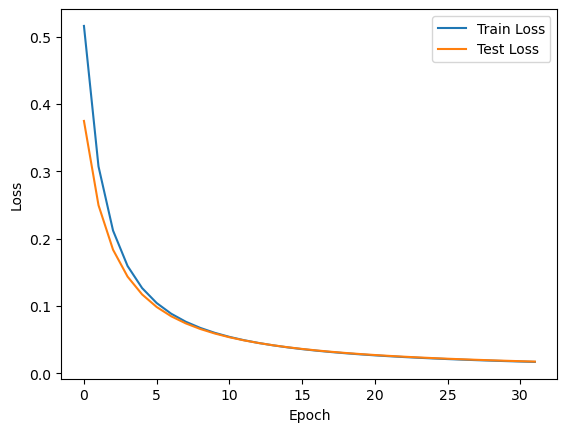

In [54]:
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 7 对回归、二分类、多分类任务分别选择上述实验中效果最好的模型，采用10折交叉验证评估实验结果
要求除了最终结果外还需以表格的形式展示每折的实验结果

In [55]:
from sklearn.model_selection import KFold


def batch_iter(
    batch_size: int, features: torch.Tensor, labels: torch.Tensor, shuffle: bool
):
    """通用的批量数据迭代器"""
    num_examples = len(features)
    if shuffle:
        indices = torch.randperm(num_examples, device=features.device)
    else:
        indices = torch.arange(0, num_examples, device=features.device)

    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i : min(i + batch_size, num_examples)]
        yield features[batch_indices], labels[batch_indices]

In [56]:
def k_fold_cross_validation(
    k: int,
    batch_size: int,
    num_epochs: int,
    device: torch.device,
    X_data: torch.Tensor,
    y_data: torch.Tensor,
    p: int,
    h: int,
) -> list[dict[str, int]]:

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results_details = []

    # 修复 kfold.split 的输入类型：传入索引数组
    dataset_indices = np.arange(len(X_data))

    print(f"--------------------------------")
    print(f"Starting {k}-Fold Cross-Validation on {len(X_data)} samples.")
    print(f"--------------------------------")

    # kfold.split() 返回的是 numpy.ndarray 类型的索引
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_indices)):
        print(f"\n[FOLD {fold + 1}/{k}]")

        # 1. 准备数据子集 (直接从原始张量中获取子集)
        # train_ids 和 val_ids 是 numpy 数组，可以直接用来索引 PyTorch 张量
        X_fold_train = X_data[train_ids]
        y_fold_train = y_data[train_ids]
        X_fold_val = X_data[val_ids]
        y_fold_val = y_data[val_ids]

        # 2. 【关键】每一折都重新初始化全新的模型和优化器
        net = Net(
            input_dim=p, hiden_dim=h, output_dim=1, device=device
        )  # output_dim=1 for BCEWithLogitsLoss
        loss_fn = Loss()
        optimizer = Optimizer(net.parameters(), lr=0.01)  # 假设 lr=0.01

        # 3. 创建这一折专用的训练和验证迭代器 (使用上面修改后的通用迭代器)
        train_iter_fn = lambda bs: batch_iter(
            bs, X_fold_train, y_fold_train, shuffle=True
        )
        val_iter_fn = lambda bs: batch_iter(bs, X_fold_val, y_fold_val, shuffle=False)

        # 4. 调用训练函数
        train_loss_hist, val_loss_hist = train(
            num_epochs,
            batch_size,
            net,
            loss_fn,
            optimizer,
            train_iter_fn,  # 传入 lambda 函数
            val_iter_fn,  # 传入 lambda 函数
            eval_loss_fn,
            device,
        )

        final_val_loss = val_loss_hist[-1]

        # 5. 记录这一折的详细结果
        fold_results_details.append(
            {
                "Fold": fold + 1,
                "Train Loss": train_loss_hist[-1],
                "Validation Loss": final_val_loss,
                "Train Size": len(train_ids),
                "Validation Size": len(val_ids),
            }
        )

        print(f"--> Fold {fold + 1} Finished. Final Val Loss: {final_val_loss:.6f}")

    return fold_results_details

In [57]:
# K 折参数
K = 10
BATCH_SIZE = 1024
EPOCHS = 32

# 注意：我们使用原始的 X_train 和 y_train 作为 K 折的整体数据
results_details = k_fold_cross_validation(
    k=K,
    batch_size=BATCH_SIZE,
    num_epochs=EPOCHS,
    device=devc,
    X_data=X_train,  # 将原始训练集作为 K 折的输入
    y_data=y_train,
    p=p,
    h=h,
)

# --- 打印表格结果 ---

validation_losses = [row["Validation Loss"] for row in results_details]
avg_loss = np.mean(validation_losses)
std_dev = np.std(validation_losses)

print(f"\n\n==========================================")
print(f"{K}-Fold 交叉验证 实验结果")
print(f"==========================================")

print("| Fold | 训练集大小 | 验证集大小 | 最终训练 Loss | 最终验证 Loss |")
print("|------|-----------|-----------|---------------|---------------|")

for row in results_details:
    print(
        f"| {row['Fold']:<4} | "
        f"{row['Train Size']:<10} | "
        f"{row['Validation Size']:<10} | "
        f"{row['Train Loss']:.6f} | "
        f"**{row['Validation Loss']:.6f}** |"
    )

print("\n--- 汇总统计 ---")
print(f"验证集平均 Loss: **{avg_loss:.6f}**")
print(f"验证集 Loss 标准差: {std_dev:.6f}")
print(f"==========================================")

--------------------------------
Starting 10-Fold Cross-Validation on 7000 samples.
--------------------------------

[FOLD 1/10]
epoch 1, train loss: 0.5909, test loss: 0.5051
epoch 2, train loss: 0.4987, test loss: 0.4302
epoch 3, train loss: 0.4281, test loss: 0.3720
epoch 4, train loss: 0.3724, test loss: 0.3258
epoch 5, train loss: 0.3278, test loss: 0.2879
epoch 6, train loss: 0.2909, test loss: 0.2575
epoch 7, train loss: 0.2610, test loss: 0.2315
epoch 8, train loss: 0.2354, test loss: 0.2099
epoch 9, train loss: 0.2141, test loss: 0.1916
epoch 10, train loss: 0.1959, test loss: 0.1759
epoch 11, train loss: 0.1801, test loss: 0.1624
epoch 12, train loss: 0.1665, test loss: 0.1505
epoch 13, train loss: 0.1545, test loss: 0.1402
epoch 14, train loss: 0.1441, test loss: 0.1311
epoch 15, train loss: 0.1348, test loss: 0.1230
epoch 16, train loss: 0.1265, test loss: 0.1157
epoch 17, train loss: 0.1191, test loss: 0.1091
epoch 18, train loss: 0.1123, test loss: 0.1032
epoch 19, train